In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#Read in puzzle embeddings generated by word2vecf
temp = pd.read_csv("250_0.16_vectors.tsv", sep=' ', header=None, skiprows=1)
#Drop empty column at the end
temp = temp.drop(len(temp.columns)-1,axis=1)
#Rename first column and set as index, then normalize vectors
temp.rename(columns={0:'puzzle_id'}, inplace=True)
temp.set_index('puzzle_id',inplace=True)
temp = temp.divide(np.linalg.norm(temp, axis=1), axis=0)

In [3]:
#Replace tag field values with first tag so that all puzzles only have one tag
#There are several ways to do assign one tag to a puzzle but this is the most simple
tag_data = pd.read_csv('../tactics_problem.csv')
def get_first_tag(row):
    tags = str(row['tags']).split(',')
    return tags[0]

tag_data['tags'] = tag_data.apply(lambda row: get_first_tag(row),axis=1)
#tag_data = tag_data.loc[(tag_data['tags'] != 'nan') & (tag_data['tags'] != 'Mate in 1')]
#Remove puzzles that have no tag
tag_data = tag_data.loc[(tag_data['tags'] != 'nan')]
#tag_data = tag_data.loc[tag_data['tags'].isna() == False]

In [4]:
#Remove embeddings for puzzles that do not have tags
shared_puzzles = pd.merge(tag_data,temp,left_on='tactics_problem_id',right_on='puzzle_id')['tactics_problem_id']
shared_puzzles.shape

In [6]:
#Sample tags and generate distance matrix of those tags
import sklearn.metrics
sample_size=1000
np.random.seed(100)
#Contain the IDs for the randomly sampled puzzles
sampled_problems = np.random.choice(shared_puzzles.values, size = sample_size, replace = False)
#Generate the cosine distance matrix (as Pandas DF) given a list of IDs in the embeddings
def generate_matrix(sampled_problems):
    vecs = temp.loc[sampled_problems]
    cos_sim = sklearn.metrics.pairwise.cosine_similarity(vecs)
    cos_dist = 1.0 - cos_sim
    #Set really small numbers to 0
    cos_dist=cos_dist.round(3)
    #Create cosine distance table
    table = pd.DataFrame(cos_dist, columns=sampled_problems,index=sampled_problems)
    return table

In [85]:
'''
#Generate color pallete for tags
sampled_tags = tag_data.set_index('tactics_problem_id').loc[sampled_problems]['tags']
tag_vals = sampled_tags.unique()
palette = sns.color_palette("hls", len(tag_vals))
lut = dict(zip(tag_vals, palette))
colors = sampled_tags.map(lut)
'''

In [7]:
#Do clustering on condendesed distance matrix
table = generate_matrix(sampled_problems)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
linkage = hc.linkage(sp.distance.squareform(table), method='complete')

In [8]:
#Test the linkage 
from scipy.cluster.hierarchy import cophenet

cophenet(linkage)[0]

0.959

In [9]:
#Cluster the puzzles into k amount of clusters and then associate each cluster category to puzzle id
from operator import itemgetter
from scipy.cluster.hierarchy import fcluster
k=20
cluster = fcluster(linkage, k, criterion='maxclust')
prob_pair = list(zip(list(sampled_problems), list(cluster)))
#prob_pair_sorted = sorted(prob_pair, key=itemgetter(1))

#problem_id_grouped = [x[0] for x in prob_pair_sorted]
#new_table = generate_matrix(problem_id_grouped)

In [26]:
print(prob_pair[:5])

[(61523, 11), (61473, 17), (61526, 18), (154829, 3), (57697, 11)]
[ 61523  61473  61526 154829  57697]
tactics_problem_id
61523       Decoy / Deflection
61473     Fork / Double Attack
61526               Mating Net
154829               Back Rank
57697                  Defense
Name: tags, dtype: object


In [10]:
#Generate cluster color pallete
nums = list(range(1,k+1))
palette = sns.color_palette("hls", k)
lut = dict(zip(nums, palette))
colors = {}
for pair in prob_pair:
    colors[pair[0]] = lut[pair[1]]
colors = pd.Series(sampled_problems,index=sampled_problems).map(colors)

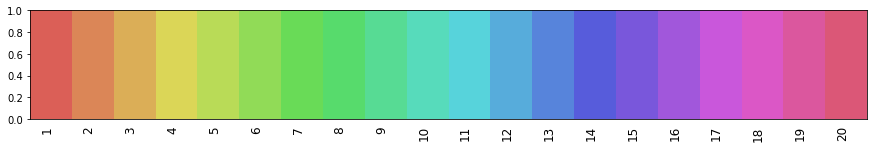

In [12]:
import matplotlib
import matplotlib.pyplot as plt

n=15
size = n/k
fig = plt.figure(figsize=(n,2))
ax = fig.add_subplot(111)
index = 0
for tag in lut:
    plt.text(index+(size/4), -0.15, tag, fontsize=12,rotation="vertical")
    rect = matplotlib.patches.Rectangle((index,0), size, 2, color=lut[tag])
    ax.add_patch(rect)
    index += size
#ax.set_xticklabels(tag_vals,)
plt.xlim([0, n]) 
plt.tick_params(axis='x',  # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

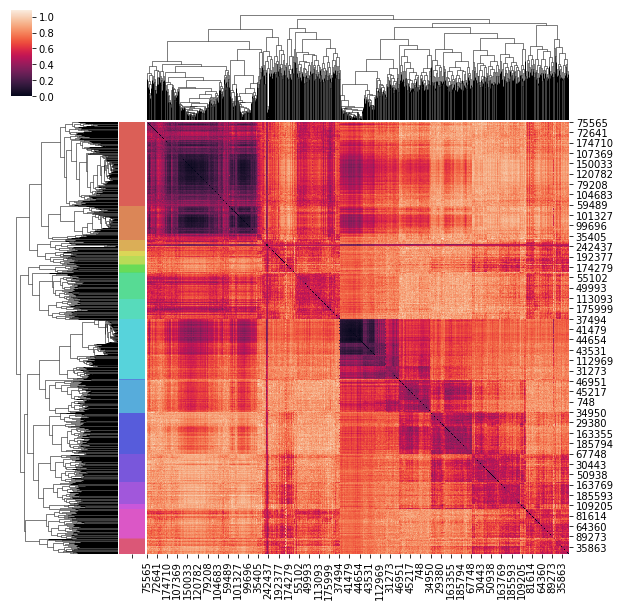

In [69]:
#Set row and column linkage to the clustering genrated above and print heatmap
import seaborn as sns
sns.clustermap(table, row_linkage=linkage, col_linkage=linkage,row_colors=colors)

In [14]:
sampled_tags = tag_data.set_index('tactics_problem_id').loc[sampled_problems]['tags']

In [40]:
#Create dictionary of clusters that map to lists of the tags in those clusters
cluster_to_tag = {}
for i in range(1,k+1):
    cluster_to_tag[i] = []

def tag_list(sampled_problems):
    for i in range(len(sampled_problems)):
        #Get Cluter ID from puzzle ID
        cluster_id = prob_pair[i][1]
        #pos = puzz_list.index(sampled_problems[i])
        #embedding = list(temp.iloc[pos,:])
        #sampled_problems[i] = embedding
        tag = sampled_tags.iloc[i]
        cluster_to_tag[cluster_id].append(tag) 
    return cluster_to_tag

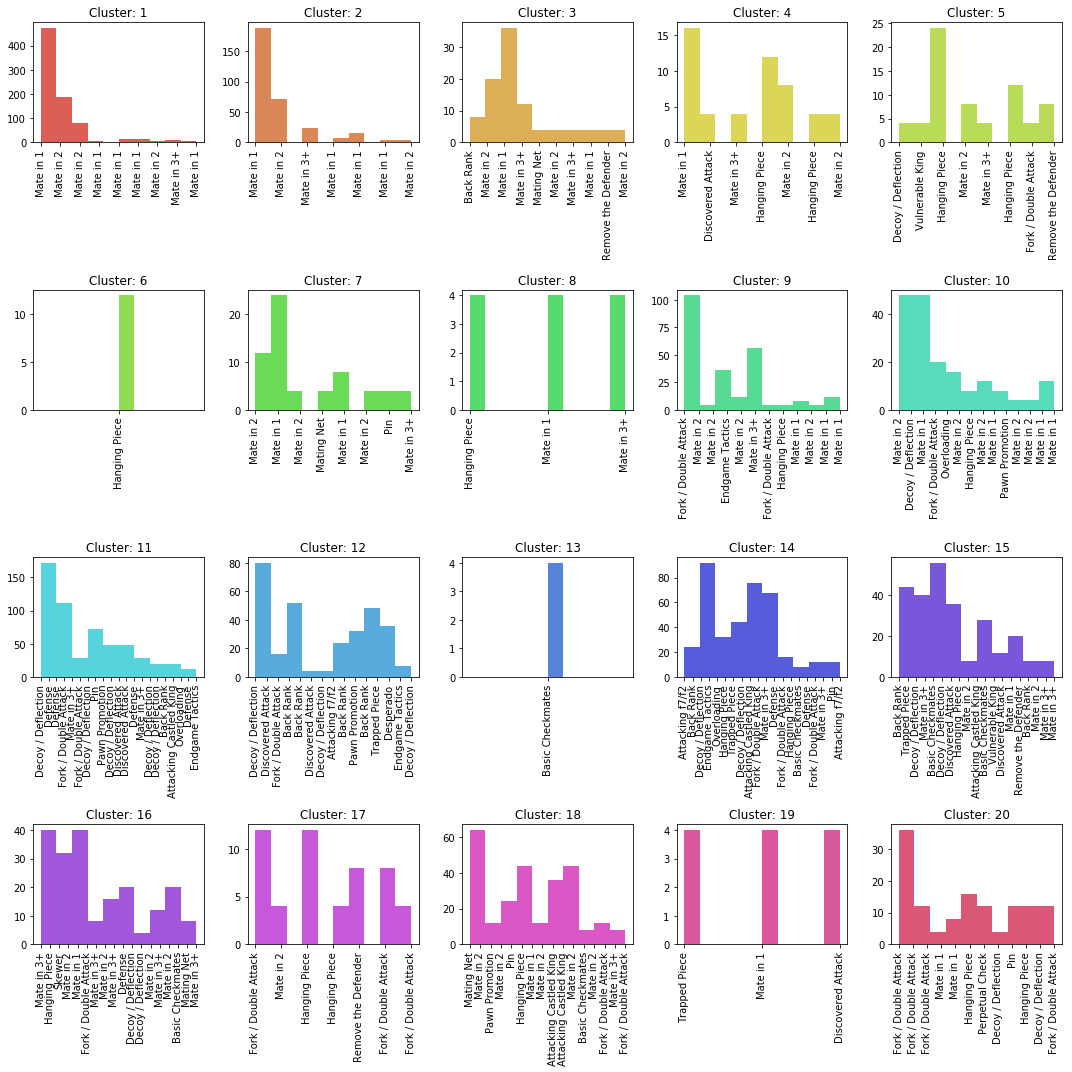

In [71]:
#Create histogramsfor 20 clusters 
fig, axs = plt.subplots(4,5,figsize=(15,15))

clust_id = 1
for i in range(4):
    for j in range(5):
        data = cluster_to_tag[clust_id]
        axs[i,j].hist(data,bins=10,color=lut[clust_id])
        axs[i,j].set_title('Cluster: '+str(clust_id))
        #axs[i,j].tick_params(axis='x',bottom=False,labelbottom=False)
        axs[i,j].set_xticklabels(data,rotation='vertical',fontsize=10)
        #ax.set_xlabel('Tag')
        #ax.set_ylabel('Frequnecy')
        clust_id += 1
plt.tight_layout()